<a id="section-title-intro"></a>
# Wide perspective query system focused on COVID-19


System that offers integral consultation of scientific papers on COVID-19 through search at document and passage level and with auxiliary visualization of the results.

Full code is available at https://github.com/Elhuyar/covid-19-IR.

Also, a minimum interactive working demo is available at http://covid19kaggle.elhuyar.eus , providing exploration and result navigation for all the queries in the challenge. 

**The system has the following features:**
* Simultaneous and complementary retrieval of documents (coarse grain) and passages (fine grain) relevant to queries.
* Visual representation of relevant documents and paragraphs according to their semantic content.

**Techniques:**
* Retrieval of documents through language models (Indri).
* Retrieval of passages by combining language models (Indri) and re-ranking based on BERT fine-tuned for sentence pair classification task.
* Visualization by means of embeddings and reduction of dimensions.

**Contributions:**
* Results and visualization according to different techniques that offer an enriched and wide perspective consultation.
* Fine-tuning of BERT by trainset built from (titles,abstracts) pairs extracted from the COVID-19 Open Research dataset.


We describe below in different steps how we have implemented the system. The steps to be explained are the following:

1. Preprocess of the collection.
2. Vectorial representation of abstracts and passages for visualization.
3. Indexing of the collection for document and passage retrieval.
4. BERT model fine-tuning for classification of related sentences of COVID-19 domain.
5. Document and passage retrieval.
6. Visualization of results.


<a id="section-preprocess"></a>
# 1 Preprocess of collections

The first step is to find the documents talking about COVID-19 in the dataset, but not about other Corona viruses. For the first version of the system we approach this task by using a keyword list. 
The list was taken from the [Kaggle COVID-19 Medical Dictionary](https://docs.google.com/spreadsheets/d/1t2e3CHGxHJBiFgHeW0dfwtvCG4x0CDCzcTFX7yz9Z2E/edit?pli=1#gid=389064679).

Below you can find the code for filtering the dataset. It reads metadata.csv file and reconstructs full text papers, looking for keywords in the whole papers.

In [ ]:

import os
import sys
import re
import collections

import csv

# Generate regex patterns for filter words, for the moment we use a simple list of terms, this ought to be more sophisticated                                                                                                                                                                                     
filterwords=["2019-nCoV","COVID-19","novel coronavirus","SARS-CoV-2","Wuhan coronavirus"]
word_patterns=collections.OrderedDict()
for w in filterwords:
    wrdlc=w.lower()
    wrdptrn=re.compile(r"\b"+re.escape(wrdlc))
    word_patterns[wrdlc]=wrdptrn

    
output=[]
processed={}
metadata=csv.DictReader('kaggle/input/metadata.csv', dialect='excel')#delimiter='\t',  quoting=csv.QUOTE_NONE) #.drop_duplicates()                                                                                                  

of=open(out_file,"w", encoding='utf-8')
fieldnames=metadata.fieldnames
fieldnames.append('keywords_found')
sys.stderr.write("fields: {}\n".format(fieldnames))

wr=csv.DictWriter(of,fieldnames=fieldnames, dialect='excel')
wr.writeheader()

skipped=0
docs_found=0
file_problems=0
for row in metadata:
    proces_count+=1
        #if proces_count > 10:                                                                                                                                                                                     
        #    sys.exit(100)                                                                                                                                                                                         
        sys.stderr.write("\r {a:8d} documents processed".format(a=proces_count))
        #sys.stderr.write("\n document sha {} and pmcid {} --> \n row {}\n".format(row["sha"],row["pmcid"],row))                                                                                                   
        #we give preference to sha over pmc                                                                                                                                                                        
        file_id=row["sha"]
        file_type="pdf_json"
        if row["sha"] == None or row["sha"] == '':
            file_id=row["pmcid"]
            file_type="pmc_json"
            #sys.stderr.write("WARN: document {} has no sha {}\n".format(row["cord_uid"],row["sha"]))                                                                                                              

            if row["pmcid"] == None or row["pmcid"] == '':
                skipped+=1
                sys.stderr.write("WARN: document {} has neither sha nor pmcid, skipping ({})\n".format(row["cord_uid"],skipped))
                continue

        if file_id in processed:
            sys.stderr.write("WARN: document with file_id {} (sha or pmcid) already processed, skipping\n".format(file_id))
        else:
            processed[file_id]=1
            if row["sha"] != None and row["pmcid"] != None:
                processed[row["pmcid"]]=1

        extension=".json"
        if file_type == "pmc_json":
            extension=".xml.json"
            
        # check if the document has more than one files asssociated, and if so parse all of them for reconstructing the full text.    
        file_ids=file_id.split("; ")
        full_text = ""
        paragraphs=[]
        sentences=[]
        for i in file_ids:
            in_file=os.path.join(inFolder,row["full_text_file"],row["full_text_file"],file_type,i+extension)
            article={}
            try: 
                with open(in_file,"r") as infile: 
                    article = json.load(infile)
                    #sys.stderr.write("current document: {}\n".format(artikulu))
            except:
                file_problems+=1
                sys.stderr.write("WARN: document with file_id {} (sha or pmcid) has problems with accessing the files, skipping\n".format(file_id))
                continue
        
            if "metadata" in article and "title" in  article["metadata"]:
                if article["metadata"]["title"] != "":
                    full_text = full_text + "\n" + article["metadata"]["title"]
                    
            if "abstract" in article and len(article["abstract"]) > 0:
                for abstract_node in article["abstract"]:
                    if abstract_node["text"] == None or abstract_node["text"] == "":
                        continue
                
                    full_text = full_text + "\n" + abstract_node["text"]
            for paragraph in article["body_text"]:
                if paragraph["text"] == None or paragraph["text"] == "":
                    continue
                
                full_text=full_text + "\n" + paragraph["text"]
           
        ## finally, once  full text is reconstructed, look for keywords
        kwords_found= []
        full_textlc = full_text.lower()
        for w,ptrn in words.items():
            if re.search(ptrn,full_textlc):
                kwords_found.append(w)
                #break # for the moment all keywords are look for, 
                             
        # if keywords are found (at the moment as single keyword is required) write the tuple including the keywords in a new column.
        if (len(kwords_found)>0):
            docs_found+=1
            row["keywords_elh"]=";".join(kwords_found)
            wr.writerow(row)
            
    of.close()

<a id="section-vect-repr"></a>
# 2 Vectorial representation of abstracts and passages for visualization

The system offers a visual representation, in addition to the textual one, of the document and passage rankings relevant to the queries submitted by the user. The visualization of documents and passages will be done in a two-dimensional plane according to their vectorial representations. We have studied bag-of-words representations as well as embedding based ones.

For the construction of vectorial representations of bags of words we tokenize the text and remove stopwords, tokens from one character and punctuation marks. We also filter out tokens that appear in less than two documents and in more than 60% of the documents in the collection. We assign tf-idf weights to the dimensions represented by the tokens, and reduce the dimensions from 10,000 to 2 in two steps: First we apply SVD to make a reduction to 50 dimensions, and then TSNE to reduce to 2 dimensions.

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import csv
from nltk.tokenize import RegexpTokenizer
import joblib
from nltk.corpus import stopwords
import string

import sys

tokenizer = RegexpTokenizer(r'\w+') 


#print(stopwords_english)
passages=True

in_file='metadata.csv_covid-19.kwrds.csv'
if passages:
    in_file='metadata.csv_covid-19.kwrds.paragraphs.csv'

with open(in_file) as tsvfile:    
    reader = csv.DictReader(tsvfile, dialect='excel')
    # output file
    out_file = in_file+".tfidf-coords.csv"
    of=open(out_file,"w", encoding='utf-8')
    fieldnames=reader.fieldnames
    fieldnames.append('tfidf_coord_x')
    fieldnames.append('tfidf_coord_y')
    sys.stderr.write("fields: {}\n".format(fieldnames))
    wr=csv.DictWriter(of,fieldnames=fieldnames, dialect='excel')
    wr.writeheader()
    
    texts=[]
    ids={}
    count=0
    output=[]
    for row in reader:
        sys.stderr.write("\r {} rows processed".format(count))
        dokid=""
        text=""
        if passages :
            dokid=row['paragraph_id']
            text=row['text']
        else:
            dokid=row['cord_uid']    
            text=row['title']+" "+row['abstract']
      
        # tokenization
        tokens = tokenizer.tokenize(text)
        tokenak=[]
        for tok in tokens:
            #filter non alphanumeric tokens and stop words
            if not (tok in string.punctuation) and not(tok.isnumeric()) and not(tok.lower() in stopwords.words('english')) and (len(tok) > 1) :
                tokenak.append(tok)
        tokenized_text=" ".join(tokenak)
        #add tokenized document
        tokenized_text=tokenized_text.lower()
        #texts list
        texts.append(tokenized_text)
        #Dokids list
        ids[dokid]=count
        count+=1
        output.append(row)

    #Generate tfidf model
    vectorizer = TfidfVectorizer(min_df=2,max_df=0.6,norm="l2",max_features=10000)
    vecfit = vectorizer.fit(texts)
    vec_trans = vecfit.transform(texts)

    
    #Dimension reduction
    tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
    svd = TruncatedSVD(n_components=50, random_state=0)
    svd_tfidf = svd.fit_transform(vec_trans)
    tsne_tfidf = tsne_model.fit_transform(svd_tfidf)
    #for i in vec_trans.toarray():
    #    print(i)
    for row in output:
        dokid='cord_uid'
        if passages:
            dokid='paragraph_id'
 
        row['tfidf_coord_x']=tsne_tfidf[ids[row[dokid]]][0]
        row['tfidf_coord_y']=tsne_tfidf[ids[row[dokid]]][1]
        
        wr.writerow(row)

    of.close()

The construction of dense vector representations by means of embeddings is similar, but in this case we use the average vector of FastText embeddings of all the words in the text. In future versions we will include representations according to contextual embeddings based on neural language models.

The code is very similar to that of tdidf based coordinate generation, following we show the changes over the aforementioned code.




In [ ]:

# Flair library is used to generate document embeddings
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentPoolEmbeddings, Sentence, ELMoEmbeddings,BertEmbeddings,DocumentRNNEmbeddings
import numpy as np
 
    #... Everything is the same as above up to the tokenization of the texts.
    
    ## Tokenization part is changed to create Flair Sentence objects
    
        #Remove stopwords?
        if stopwords_flag:
            tokens = tokenizer.tokenize(text)
            tokenak=[]
            for tok in tokens:
                #filter non alphanumeric tokens and stop words
                if not (tok in string.punctuation) and not(tok.isnumeric()) and not(tok.lower() in stopwords.words('english')) and (len(tok) > 1) :
                    tokenak.append(tok)
            tokenized_text=" ".join(tokenak)
            text=tokenized_text.lower()

        sentence = Sentence(text,use_tokenizer=True)
        #sentence.tokens = sentence.tokens[:100]        
        if len(sentence)>0:
            document_embeddings.embed(sentence)
            new_row=sentence.get_embedding().detach().numpy()
            #sys.stderr.write("row shape: {}\n".format(new_row.shape))
        else:
             new_row=np.zeros(300)
        if len(A)==0:
            A=new_row
        else:
            A = np.vstack((A, new_row))   

       ## ...   
            
    #Dimension reduction
    tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
    svd = TruncatedSVD(n_components=50, random_state=0)
    svd_A = svd.fit_transform(A)
    tsne_A = tsne_model.fit_transform(svd_A)

    for row in output:
        dokid='cord_uid'
        if passages:
            dokid='paragraph_id'
 
        row['fasttext_coord_x']=tsne_A[ids[row[dokid]]][0]
        row['fasttext_coord_y']=tsne_A[ids[row[dokid]]][1]
        
        wr.writerow(row)

<a id="section-index"></a>
# 3 Indexing of the collection for document and paragraph retrieval

In order to obtain the relevant documents and passages of the collection corresponding to the queries, we use a language modeling based information retrieval approach (Ponte & Croft, 1998) combined with weighted structured queries (Darwish & Oard, 2003) in order to deal with the translation selection problem. For that purpose, we used the Indri search engine (Strohman, 2005), which combines Bayesian networks with language models.

We indexed two collections: one of documents and one of paragraphs. For each document we index its title and abstract, and for each paragraph its corresponding paragraph.
We convert the initial collections to TREC format.

In [ ]:
import csv

#cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url,keywords_elh
with open('/media/nfs/multilingual/kaggle-covid19/metadata.csv_covid-19.kwrds.csv') as tsvfile:    
    reader = csv.reader(tsvfile, dialect='excel')
    #Dont print header
    next(reader)
    for row in reader:
        dokid=row[0]
        title=row[3]
        abstract=row[8]
        print("<DOC>")
        print("<DOCID>"+dokid+"</DOCID>")
        print("<DOCNO>"+dokid+"</DOCNO>")
        print("<TEXT>\n"+title+"\n"+abstract+"\n</TEXT>")
        print("</DOC>")

In [ ]:
import csv

#cord_uid,paper_id,paragraph_id,paragraph_type,text
with open('/media/nfs/multilingual/kaggle-covid19/metadata.csv_covid-19.kwrds.paragraphs.csv') as tsvfile:    
    reader = csv.reader(tsvfile, dialect='excel')
    #Dont print header
    next(reader)
    for row in reader:
        par_id=row[2]
        text_type=row[3]
        par_text=row[4]
        if text_type == "body":
            print("<DOC>")
            print("<DOCID>"+par_id+"</DOCID>")
            print("<DOCNO>"+par_id+"</DOCNO>")
            print("<TEXT>\n"+par_text+"\n</TEXT>")
            print("</DOC>")

Then, we create indexing configuration files parameter.file and parameterPar.file to create the two indexes using the IndriBuildIndex command. The indexes are created in the BildumaIndex and BildumaParIndex folders.

In [ ]:
buildindex/IndriBuildIndex parameter.file
buildindex/IndriBuildIndex parameterPar.file

<a id="section-reranking"></a>
# 4 BERT model fine-tuning for classification of related sentences of COVID-19 domain

BERT models have been successfully used to reorder rankings obtained by classic IR algorithms based on word bags. As they are heavy models they are only applied to the top of the rankings.

In our case we propose to make a re-ranking based on BERT on the paragraph ranking following a strategy similar to the one proposed by Nogueira and Cho (2019).
As we do not have a collection of query pairs and relevant paragraphs, we simulate a training collection composed of titles and their corresponding abstracts from the COVID-19 Open Research dataset. Through this training collection we tuned the BERT model to the task of identifying relevant queries and paragraphs.

### Reranking by means of Fine-tuned BERT for sentence pair classification

Clinical BERT (Bio+ClinicalBERT) (Alsentzer et al., 2019) finetuned for sentence pair classification, over two datasets:
- Titles as queries + abstracts as passages, from CORD-19 kaggle dataset. 
- MedQuAD question answering dataset (Ben Abacha & Demner-Fushman, 2019). Medline Plus collections were discarded.

All datasets in this section were randomly split 80/20 for train/test (no development set was used as we train for a fixed number of steps (4 epochs).




The first step is preparing the dataset for finetuning BERT models. The title-abstract collection is straightforward, we just need to extract title and abstract pairs in BERT readable format. 

In [ ]:
import csv
import random


titles={}
absts={}


with open('/data/input/metadata.csv') as tsvfile:    
    reader = csv.reader(tsvfile, delimiter=',',quotechar='"')
    #Don't print header
    next(reader)
    for row in reader:
        dokid=row[0]
        title=row[3]
        abstract=row[8]
        if abstract.strip() != "" and title.strip() != "": 
            titles[dokid]=title
            absts[dokid]=abstract


for dokid in titles:
    # positive examples
    print(titles[dokid]+"\t"+dokid+"\t"+absts[dokid]+"\t"+dokid+"\t1")
    #negative examples (1:10 positve:negative ratio)
    for i in range(10):
        dokid2=random.choice(list(absts.keys()))
        print(titles[dokid]+"\t"+dokid+"\t"+absts[dokid2]+"\t"+dokid2+"\t0")


Now for the finetuning part we use original BERT distribution [run_classifier.py](https://github.com/google-research/bert/blob/master/run_classifier.py) finetuning script, with a custom data processor very similar to the one used for MRPC dataset (only minimal changes done to the _create_examples function to adapt it to our needs.). 

In [ ]:
class CovidKaggleProcessor(DataProcessor):
  """..."""

  def get_labels(self):
    """See base class."""
    return ["0", "1"]

  def _create_examples(self, lines, set_type):
    """Creates examples for the training and dev sets."""
    examples = []
    for (i, line) in enumerate(lines):
      guid = "%s-%s" % (set_type, i)
      text_a = tokenization.convert_to_unicode(line[0])
      text_b = tokenization.convert_to_unicode(line[2])
      if set_type == "test":
        label = tokenization.convert_to_unicode(line[4])
    else:
        label = tokenization.convert_to_unicode(line[4])
      examples.append(
          InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
    return examples


Finetuning is done over Bio+ClinicalBERT for 4 epochs, with a bastch size of 16 in order to fit into our GPU (GeForce 2080 RTX Ti). Following the exact command used:

In [ ]:
BERT_BASE_DIR="clinicalBert/pretrained_bert_tf/biobert_pretrain_output_all_notes_150000"

python -u run_classifier.py  --task_name=covid \
       --do_train=true \
       --do_eval=true \
       --data_dir=$GLUE_DIR \
       --vocab_file=$BERT_BASE_DIR/vocab.txt \
       --bert_config_file=$BERT_BASE_DIR/bert_config.json \
       --init_checkpoint=$BERT_BASE_DIR/model.ckpt-150000 \
       --max_seq_length=128 \
       --train_batch_size=16 \
       --learning_rate=2e-5 \
       --num_train_epochs=4.0 \
       --output_dir=$GLUE_DIR/output-4e-1 \
       --do_lower_case=False \

Training results for reranking finetuning over the COVID-19 title-abstract collection.


------------ Result of Bert fine-tuned model ----------

              precision    recall  f1-score   support

           0     0.9962    0.9976    0.9969     77791
           1     0.9761    0.9620    0.9690      7782

    accuracy                         0.9944     85573
    macro avg    0.9862    0.9798    0.9830     85573
    weighted avg 0.9944    0.9944    0.9944     85573

--------------------------------------------------------

Results are very good. We repeated the experiment with the MedQuAD dataset, but results weren't nearly as good. Specifically the following experiments were further carried out:
* MedQuAd Dataset.
* MedQuAd Dataset prunned, leaving out question/answer pairs whose answers are longer than 150 tokens.
* Combination of MedQuAD and COVID-19 title-abstract dataset.

MedQuAD dataset had a very low recall (0.1 - 0.20) for positive examples, leading to a very low performance. Prunning out long answer improved the results on MedQuAD by 10 points, but still far from the results of the COVID-19 title-abstract dataset. Thus we used the BERT model finetuned over that dataset for reranking.

Reranking is done by means of linear combination between the rank score returned by INDRI and the probability to be a correct answer returned by BERT.





<a id="section-retrieval"></a>
# 5 Document and passage Retrieval 

As explained in step 3, we use the Indri model to retrieve the documents and passages relevant to the queries submitted by the user. To implement this step we used Pyndri (Van Gysel et al., 2017), an Indri interface for Python.

In the case of document queries, we retrieve the ranking of the 50 most relevant documents and normalize their scores using the Minmax strategy.

In [ ]:
import pyndri
from nltk.tokenize import RegexpTokenizer

import pandas as pd
import json
import sys
import os
import random
import argparse

import csv

from math import exp

## 1.- First of all various metadata files containing the information enrichment done in the previous steps are loaded.

metadata="metadata.csv_covid-19.kwrds.csv"
passage_metadata="metadata.csv_covid-19.kwrds.paragraphs.csv"
    
# metadata for documents
metadata_doc=pd.read_csv(os.path.join(metadata_path,metadata))

# metadata for passages.
metadata_pas=pd.read_csv(os.path.join(metadata_path,passage_metadata))

# reranking scores are computed previously at this point. In a future version the system will work with open queries an compute this scores on the fly
reranking_scores_df=pd.DataFrame(columns=["query_candidate_id","label","neg_score","pos_score"])
# if exists, reranking-scores file
if os.path.isfile(reranking_scores):
    reranking_scores_df=pd.read_csv(reranking_scores,dialect='excel-tab')


## 2.- next step is to load indri indexes

# indri
index_doc_path=os.path.join(index_root,'Indri_doc_Index')
index_pas_path=os.path.join(index_root,'Indri_passage_Index')

index_doc = pyndri.Index(index_doc_path)
index_pas = pyndri.Index(index_pas_path)

#query tokenizer
tokenizer = RegexpTokenizer(r'\w+')

##  3.- Now comes the retrieval part. For the moment we use a close set of queries including all the questions proprosed in the various challenge tasks. Queries are stored in a tsv file.
queries_df = pd.read_csv(queries,dialect='excel-tab')
for index, row in queries_df.iterrows():

    # lowercasing and tokenization
    querylc = row['query'].lower()
    tokens = tokenizer.tokenize(querylc)        
    tokenized_query=" ".join(tokens)

    # document level results
    results = index_doc.query(tokenized_query, results_requested=maxdocs)
    docs = process_results(results,index_doc,metadata_doc, metadata_pas, reranking_scores_df, row["id"])

    # pasage level results
    results = index_pas.query(tokenized_query, results_requested=maxdocs)
    pas = process_results(results,index_pas,metadata_doc, metadata_pas, reranking_scores_df, row["id"], passages=True)

    query_json={"query_id":row['id'], "task": row['task'], "query":row['query'], "docs":docs,"pas":pas}
    output.append(query_json)

## final output is a json ready for visualization with bokeh as we will see in section 6
print(json.dumps(output, indent=4, sort_keys=True))





The function "process_results" we see above takes care of gathering metadata from the different resources loaded above and generate a json object for each candidate in the ranking. We can see the function below.

In the case of passages, after obtaining the ranking of the 50 most relevant passages and normalizing their scores, we reorder the ranking taking into account the probabilities returned by the BERT model tuned to the classification task of similar sentence pairs (see step 4). It is a similar strategy to the one proposed by Nogueira and Cho (2019).

In our case, we linearly combine the normalized Indri score and the probability of the tuned BERT model according to the following formula: final_score(candidate_i) = k*i_score + (1-k)*bert_score

For this demo we have set an initial value k=0.8 which will be tuned in the next phase.

In [ ]:
def process_results(indri_results,index,metadata_df, metadata_pas_df, reranking_scores_df, query_id, passages=False):
    output=[]
    count=0

    # Minmax score normalization for indri_scores
    min=1
    max=0
    for int_document_id, score in indri_results:
        if exp(score) < min:
            min=exp(score)
        if exp(score) > max:
            max=exp(score)

    #loop throgout result and prepare output
    for int_document_id, score in indri_results:
        count+=1
        ext_document_id, _ = index.document(int_document_id)

        doc_id = ext_document_id
        sys.stderr.write("\r processed {} documents {} ".format(count, ext_document_id))
        snippet=""
        if passages == True:
            passage_metadata_row = metadata_pas_df[metadata_pas_df["paragraph_id"]==int(ext_document_id)]
            if passage_metadata_row.empty:
                sys.stderr.write("\r no passage metadata for document {} \n ".format(ext_document_id))
                continue

            doc_id=passage_metadata_row.iloc[0]["cord_uid"]
            snippet=passage_metadata_row.iloc[0]["text"]

        # common fields for documents and passages
        doc_metadata_row = metadata_df[metadata_df["cord_uid"]==doc_id]
        if doc_metadata_row.empty:
            sys.stderr.write("\r no document metadata for document {} \n ".format(ext_document_id))
            continue
        url=doc_metadata_row.iloc[0]["url"]
        title=doc_metadata_row.iloc[0]["title"]
        author=doc_metadata_row.iloc[0]["authors"]
        journal=doc_metadata_row.iloc[0]["journal"]
        publish_date=doc_metadata_row.iloc[0]["publish_time"]
        
        # coordinates of the document/passage. Here tfidf is mentioned, but embedding-based coordinate are also used
        coords = {"coord_x":doc_metadata_row.iloc[0]["tfidf_coord_x"],"coord_y":doc_metadata_row.iloc[0]["tfidf_coord_y"],}
        if passages == True:
            coords = {"coord_x":passage_metadata_row.iloc[0]["tfidf_coord_x"],"coord_y":passage_metadata_row.iloc[0]["tfidf_coord_y"],}

        #reranking starts now
        q_candidate_id="q-"+str(query_id)+"-"+str(doc_id)
        if passages == True:
            q_candidate_id = q_candidate_id+"_"+ext_document_id
            
        bert_score=None #bert score, if not found do not take it into account
        reranking_score_row=reranking_scores_df[reranking_scores_df["query_candidate_id"]==q_candidate_id]
        if not reranking_score_row.empty:
            bert_score=reranking_score_row.iloc[0]["pos_score"]
            #sys.stderr.write("bert score for candidate {}: {} \n".format(q_candidate_id,bert_score))
            
        indri_score=(exp(score)-min)/(max-min)  # normalized indri score

        ## reranking is only applied to passages, not documents
        if passages == True and bert_score != None:
            ranking_score=0.8*indri_score+0.2*bert_score
        else:
            ranking_score=indri_score
                
        if passages == False:
            snippet=doc_metadata_row.iloc[0]["abstract"]
        
        ## end of reranking

        #generate uniq doc_ids for both pas and docs
        if passages == True:
            doc_id= doc_id+"_"+ext_document_id
        
        doc ={"doc_id":doc_id, "title":title, "journal":journal,"author":author,"publish_date":publish_date, "url":url,"text":snippet,"ranking_score":ranking_score, "indri_score":indri_score, "coordinates": coords}
        output.append(doc)
        #print(ext_document_id, score)

    return output

<a id="section-vis"></a>
# 6 Visualization / User Interface

The system offers the relevant information to the query by means of two rankings. The first ranking corresponds to the relevant documents, and the second to the relevant passages. The rankings are offered in two formats, one textual and one graphic.

The document ranking allows the user to search for articles relevant to the query. The passage ranking, on the other hand, allows for finer searches and makes it possible to find the precise relevant information required.

The system presents both rankings at the same time because we believe they are complementary, and one can help to understand the results of the other. For the same reason they are interconnected, and if you select a result from one ranking, its related result is highlighted in the other.

On the other hand, the graphic visualization of the rankings helps to understand the degree of convergence or semantic relation, at content level, between the different results.

In [ ]:
import json
import os
import math
from bokeh.palettes import RdBu3
from bokeh.models import ColumnDataSource, LabelSet, DataTable, TableColumn, Div
from bokeh.models.callbacks import CustomJS
from bokeh.models.selections import Selection
from bokeh.io import output_notebook, push_notebook, show
from bokeh.plotting import figure, output_file, save, curdoc
from bokeh.layouts import row, gridplot, layout


BOX_WIDTH = 400
BOX_HEIGHT = 340
TEXT_MAX_LEN = 1000


def parse_json(fpath):
    queries = []
    with open(fpath, 'r') as f:
        queries_j = json.load(f)
        for query_j in queries_j:
            query = {
                'id': query_j['query_id'],
                'title': query_j['query'],
                'task': query_j['task'],
                'docs': parse_entries(query_j['docs']),
                'pas': parse_entries(query_j['pas'])
            }
            queries.append(query)
    return queries
    

def parse_entries(entries):
    _ents = []
    for entry in entries:
        _ent = {
            'doc_id': parse_doc_id(entry['doc_id']),
            'score': entry['ranking_score'],
            'title': entry['title'],
            'coord_x': entry['coordinates']['coord_x'],
            'coord_y': entry['coordinates']['coord_y'],
            'text': entry['text'] if type(entry['text'])==str else "",
            'authors': entry['author'] if type(entry['author'])==str else "",
            'journal': entry['journal'] if type(entry['journal'])==str else "",
            'url': entry['url'] if type(entry['url'])==str else "",
            'date': entry['publish_date'],
        }
        _ents.append(_ent)
        _ents.sort(key=lambda p: p['score'], reverse=True)
    return _ents


def parse_doc_id(doc_id):
    _ind = doc_id.find('_')
    if _ind < 0:
        return doc_id
    else:
        return doc_id[:_ind]



    
def create_plots(query, path):
    output_file('{}/{}_{}.html'.format(path, query['task'], query['id']))
    rankd = query['docs']
    rankp = query['pas']   
    
    # document ranking data
    dscores = [ p['score'] for p in rankd ]
    source_doc = ColumnDataSource(dict(
        doc = [ p['doc_id'] for p in rankd ],
        x = [ p['coord_x'] for p in rankd ],
        y = [ p['coord_y'] for p in rankd ],
        scr = [ round(p['score'], 3) for p in rankd ],
        rad = [ get_circle_size(p['score'], dscores) for p in rankd ],
        color = [ RdBu3[0] for p in rankd ],
        title = [ p['title'] for p in rankd ],
        text = [ p['text'][:TEXT_MAX_LEN]+'...' if len(p['text'])>TEXT_MAX_LEN else p['text'] for p in rankd ],
        authors = [ p['authors'] for p in rankd ],
        journal = [ p['journal'] for p in rankd ],
        url = [ p['url'] for p in rankd ],
        date = [ p['date'] for p in rankd ],
    ))

    # paragraph ranking data
    pscores = [ p['score'] for p in rankp ]
    source_par = ColumnDataSource(dict(
        doc = [ p['doc_id'] for p in rankp ],
        x = [ p['coord_x'] for p in rankp ],
        y = [ p['coord_y'] for p in rankp ],
        scr = [ round(p['score'], 3) for p in rankp ],
        rad = [ get_circle_size(p['score'], pscores) for p in rankp ],
        color = [ RdBu3[2] for p in rankp ],
        title = [ p['title'] for p in rankp ],
        text = [ p['text'] for p in rankp ],
        authors = [ p['authors'] for p in rankp ],
        journal = [ p['journal'] for p in rankp ],
        url = [ p['url'] for p in rankp ],
        date = [ p['date'] for p in rankp ],
    ))

    # plots
    doc_sp = create_scatter_plot(source_doc, True)
    doc_tab = create_table(source_doc, True)
    par_sp = create_scatter_plot(source_par, False)
    par_tab = create_table(source_par, False)

    # selection callbacks
    source_doc.selected.js_on_change('indices', CustomJS(args=dict(sd=source_doc, sp=source_par), code="""
    if (sd.selected.indices.length == 0) {
      return;
    }
    var sel = sd.selected.indices[0];
    var new_selected = [];
    for (var i = 0; i < sp.data['doc'].length; i++) {
      if (sp.data['doc'][i] == sd.data['doc'][sel]) {
        new_selected.push(i);
      }
    }
    if (JSON.stringify(new_selected) != JSON.stringify(sp.selected.indices) &&
    !(sp.selected.indices.length == 1 && new_selected.includes(sp.selected.indices[0]))) {
      sp.selected.indices = new_selected;
      sp.change.emit();
    }
    """))
    source_par.selected.js_on_change('indices', CustomJS(args=dict(sd=source_doc, sp=source_par), code="""
    if (sp.selected.indices.length == 0) {
      return;
    }
    var sel = sp.selected.indices[0];
    var new_selected = [];
    for (var i = 0; i < sd.data['doc'].length; i++) {
      if (sd.data['doc'][i] == sp.data['doc'][sel]) {
        new_selected.push(i);
      }
    }
    if (JSON.stringify(new_selected) != JSON.stringify(sd.selected.indices) &&
    !(sd.selected.indices.length == 1 && new_selected.includes(sd.selected.indices[0]))) {
      sd.selected.indices = new_selected;
      sd.change.emit();
    }
    """))

    interface_layout=layout([[Div(text="<h2>{}</h2>".format(query['title']), sizing_mode="stretch_width")],
                   [Div(text="<h3>Document ranking</h3>")], [doc_tab, doc_sp],
                   [Div(text="<h3>Paragraph ranking</h3>")], [par_tab, par_sp]])
    
    # save layout
    #save(interface_layout)
    output_notebook()
    show(interface_layout)#, notebook_handle=True)
    
    
def create_scatter_plot(source, isdoc=True):
    tooltips = [
        ("Title", "@title"),
        ("Abstract" if isdoc else "Passage", "@text"),
        ("Published", "@date"),
        ("Authors", "@authors"),
        ("Journal", "@journal"),
        ("URL", "@url")
    ]
    p = figure(x_range=(0, 1), y_range=(0, 1), plot_width=BOX_WIDTH, plot_height=BOX_HEIGHT, tools='tap,reset', tooltips=tooltips, toolbar_location="below")
    p.circle(x='x', y='y', radius='rad', color='color', source=source)
    
    labels = LabelSet(x='x', y='y', text='title', level='glyph', text_font_size="10pt",
                      x_offset=-10, y_offset=5, source=source, render_mode='canvas')
    #p.add_layout(labels)

    return p


def create_table(source, isdoc=True):
    columns = [
        TableColumn(field="scr", title="Score", width=30),
        TableColumn(field=("title" if isdoc else "text"), title=("Document title" if isdoc else "Passage"), width=770),
    ]
    table = DataTable(source=source, columns=columns, width=BOX_WIDTH, height=BOX_HEIGHT)

    return table


def get_circle_size(score, all_scores):
    min_a = 0.0
    max_a = 1.0
    min_b = 0.003
    max_b = 0.02
    return (((score - min_a) / (max_a - min_a)) * (max_b - min_b)) + min_b



os.makedirs("visualization/html", exist_ok=True)
queries = parse_json("/kaggle/input/covid19-challenge-all-task-queriesir-rankings/all_queries_processed_random_coords.json")

#example query visualization
create_plots(queries[2], "visualization/html")

# Code for processing all the queries. For the purpose of this notebook a single query is processed in the line above.
#for query in queries:
#    create_plots(query, "visualization/html")

### Interaction

Both rankings and visualizations are connected. When a document is selected, all the passages that belong to that document and appear in the passage ranking are higlighted. We can also hover over the graph circles and explore the details of each document. A minimum interface is available at github to explore all the queries and their corresponding results.

As mentioned in the introduction, a minimum interactive working demo is available at http://covid19kaggle.elhuyar.eus, providing exploration and result navigation for all the queries in the challenge.

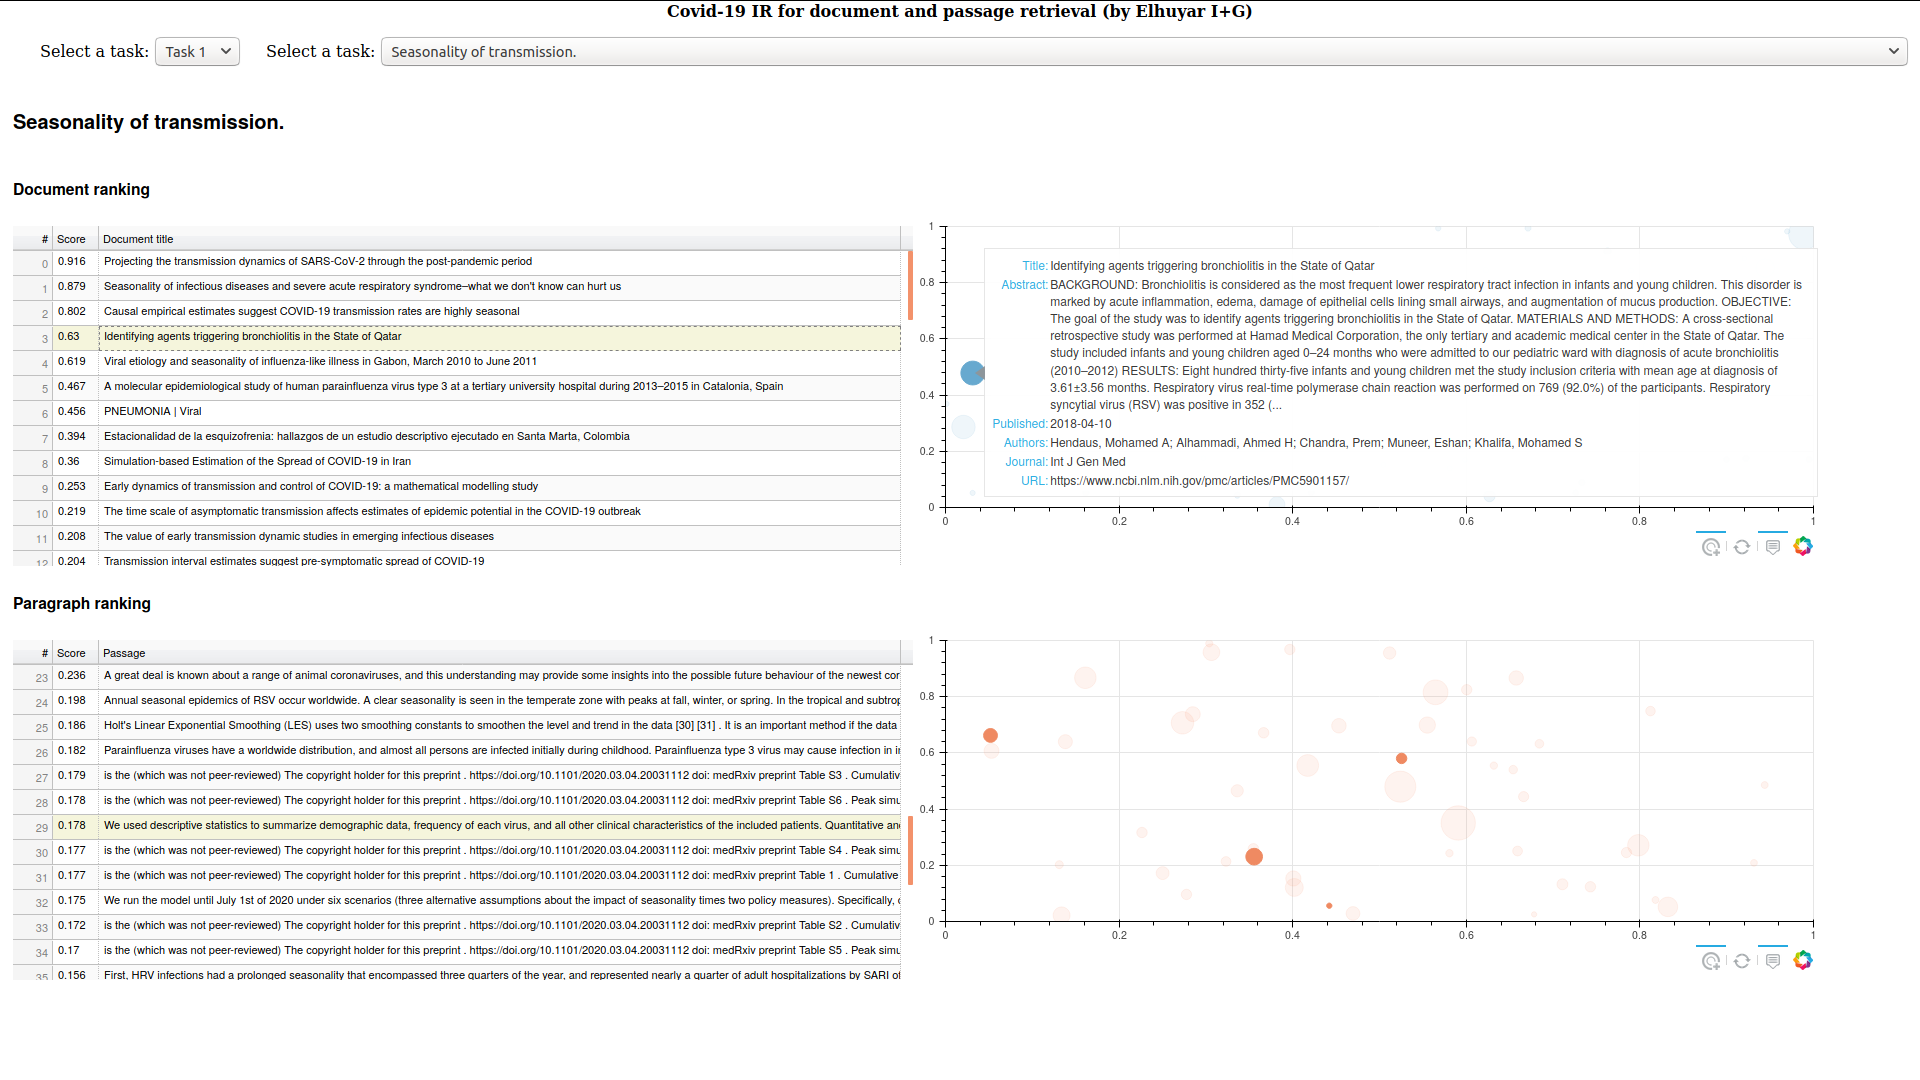


<a id="section-future"></a>
# 7 Ongoing and Future Work

Future work will focus on two main fronts, research on the one hand, and functionality on the other.

As for research, the following issues will be addressed:

* Study of contextual embeddings adapted to the medical field for the visual representation of documents and passages.
* Study of new approaches to generate silverdata for tuning the BERT model of passage reranking.

Regarding the functionality of the system, we are already working on the following improvements:
* Improvement of the user interface:
* * Improve the formatting of the ranking results: better layout, pagination, and inclusion of metadata (authors, date...).
* * Open query interface.
* Update collection dinamically as new dataset versions are published
